In [45]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, LeakyReLU
from keras.layers import Embedding, Concatenate, Input, Reshape
from keras.layers import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD, Adam
from keras.utils import np_utils

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot as plt

from keras.layers import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from tensorflow import Tensor
import matplotlib.pyplot as plt
import numpy as np
from numpy import expand_dims

%matplotlib inline

In [46]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  #Entrada codicional, la clase, que es cambiada de tamaño para concatenarla con la imagen
	in_label = Input(shape=(1,)) 
  #Embedding para respresentar las clases en vectores de 50
	li = Embedding(n_classes, 50)(in_label) 
	n_nodes = in_shape[0] * in_shape[1]
  #Se pasa por una Dense para que sea de tamaño 28x28
	li = Dense(n_nodes)(li)
  #Se transforma como si fuera un canal más
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  
    
    
  #Imagen de entrada
	in_image = Input(shape=in_shape) #28x28x1
  #Se concatenan la imagen y la entrada condicional
	merge = Concatenate()([in_image, li]) #28x28x2

  #Capas para discriminar la imagen
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same')(merge) 
	fe = LeakyReLU(alpha=0.2)(fe)
	fe= Dropout(0.25)(fe)

	fe = Conv2D(64, (3,3), strides=(2,2),padding='same')(fe) 
	fe = LeakyReLU(alpha=0.2)(fe)
	fe= Dropout(0.25)(fe)
 
	fe = Flatten()(fe)
	fe = Dense(512, activation='relu')(fe)
	fe = Dropout(0.25)(fe)
	
	out_layer = Dense(1, activation='sigmoid')(fe)

    
	# Se define el modelo con las dos entradas
	model = Model([in_image, in_label], out_layer)
	
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [47]:
def define_generator(latent_dim, n_classes=10):
  #etiqueta condicional
	in_label = Input(shape=(1,)) 
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
  #Se necesitará una salida un tamaño de 7x7 para concaternar con la entrada que genera la imagen
	n_nodes = 7 * 7  
	li = Dense(n_nodes)(li) 
	li = Reshape((7, 7, 1))(li)
 
	# Entrada que produce la imagen
	in_lat = Input(shape=(latent_dim,))
  #Se transforma a 7x7 que más tarde será escalado a 28x28 para la salida hacia el discriminador
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
 
	# Se concatenan las entradas
	merge = Concatenate()([gen, li])  #7x7x129
  
	gen = Conv2DTranspose(128, (3,3), activation='relu', strides=(2,2), padding='same')(merge) #14x14x128
	gen = BN(momentum=0.8)(gen)

	gen = Conv2DTranspose(64, (3,3), activation='relu', strides=(2,2), padding='same')(gen) #28x28x128
	gen = BN(momentum=0.8)(gen)

	#Se usa tanh para que la imagen generada este entre [-1,1], podría ser sigmoid para [0,1]
	out_layer = Conv2D(1, (3,3), activation='tanh', padding='same')(gen) #28x28x1
	
	model = Model([in_lat, in_label], out_layer)
	return model

In [48]:
def define_gan(g_model, d_model):
	d_model.trainable = False  #El discriminador no se entrena junto al generador
    
  #Se coge la entrada del modelo generador  
	gen_noise, gen_label = g_model.input
  #También su salida
	gen_output = g_model.output  #289x28x1
    
	#La salida y la etiqueta son la entrada del discriminador
	gan_output = d_model([gen_output, gen_label])
 
	#Se crea el modelo con la entrada dicha y la salida del discriminador
	model = Model([gen_noise, gen_label], gan_output)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
  #Se usa binary_crossentropy porque discrimina si es o no real
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [49]:
def load_real_samples():
	#Se carag el dataset
	(trainX, trainy), (_, _) = mnist.load_data()  
 	
	X = expand_dims(trainX, axis=-1)

	X = trainX.astype('float32')
 
	# se escalan en el rango de [-1,1] ya que el modelo usa tanh
	X = (X - 127.5) / 127.5   
	return [X, trainy]

In [50]:
def generate_real_samples(dataset, n_samples):
	images, labels = dataset  
	# selecciona muestras al azar
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]

	#Genera unos para asignar los datos a que son imagenes reales
	y = ones((n_samples, 1))  
	return [X, labels], y #tenemos la imagen, la clase a la pertenece y que es real

In [51]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# Se crean puntos de los cuales se generan las imagenes
	x_input = randn(latent_dim * n_samples)
	# Genera tantas entradas como se quiere
	z_input = x_input.reshape(n_samples, latent_dim)
	# Selecciona entre las 10 clases una al azar para cada muestra
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels] #Se obtiene el vector que genera cada imagen y su etiqueta de clase

In [52]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# El generador crea una imagen a partir de su entrada
	images = generator.predict([z_input, labels_input])
	# Pone a 0 todas la imagenes creadas ya que son falsas
	y = zeros((n_samples, 1)) 
	return [images, labels_input], y #Tenemos una imagen generada, su etiqueta y que no es real

In [53]:
def sample_images( g_model, image_grid_rows=2, image_grid_columns=5):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, 100))
    labels = np.arange(0, 10).reshape(-1, 1)
    gen_imgs = g_model.predict([z, labels])
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10,4), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            axs[i,j].set_title("Digito: %d" % labels[cnt])
            cnt += 1

In [54]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
  # Se le pasan mitad imagenes reales mitad falsas
	half_batch = int(n_batch / 2) 
	losses=[]

	for i in range(n_epochs):
		for j in range(bat_per_epo):
			
      #Se entrena el discriminador en base a las imagenes que le pasas, mitad reales y falsas
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
			# Pasamos a la parte del entrenamiento del generador en base al discriminador
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            
      # Se pone a verdadera la imagen porque tendría que ser etiquetada como real
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
				
		if i % 2 == 0:
					g_model.save('generative.h5')
					d_model.save('discriminative.h5')
					gan_model.save('gan.h5')
					print("salvado")
					
		sample_images(g_model)
		losses.append((d_loss_real, d_loss_fake))
        
   
	

2/2 [==============================] - 0s 4ms/step
Epoch>1, Batch1/468, d1=0.751, d2=0.695 g=0.607
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch2/468, d1=0.447, d2=0.736 g=0.507
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch3/468, d1=0.286, d2=0.850 g=0.419
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch4/468, d1=0.203, d2=0.990 g=0.375
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch5/468, d1=0.182, d2=1.083 g=0.366
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch6/468, d1=0.202, d2=1.059 g=0.385
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch7/468, d1=0.251, d2=0.991 g=0.413
2/2 [==============================] - 0s 6ms/step
Epoch>1, Batch8/468, d1=0.298, d2=0.893 g=0.420
2/2 [==============================] - 0s 3ms/step
Epoch>1, Batch9/468, d1=0.352, d2=0.787 g=0.409
2/2 [==============================] - 0s 4ms/step
Epoch>1, Batch10/468, d1=0.377, d2=0.700 g=0.359
2/2 [====

C:\Users\Mark\AppData\Local\Temp\ipykernel_6892\1715371979.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10,4), sharey=True, sharex=True)


Epoch>22, Batch1/468, d1=0.667, d2=0.709 g=0.817
2/2 [==============================] - 0s 5ms/step
Epoch>22, Batch2/468, d1=0.616, d2=0.680 g=0.805
2/2 [==============================] - 0s 4ms/step
Epoch>22, Batch3/468, d1=0.659, d2=0.634 g=0.818
2/2 [==============================] - 0s 6ms/step
Epoch>22, Batch4/468, d1=0.686, d2=0.697 g=0.834
2/2 [==============================] - 0s 5ms/step
Epoch>22, Batch5/468, d1=0.661, d2=0.552 g=0.837
2/2 [==============================] - 0s 4ms/step
Epoch>22, Batch6/468, d1=0.701, d2=0.632 g=0.806
2/2 [==============================] - 0s 5ms/step
Epoch>22, Batch7/468, d1=0.650, d2=0.631 g=0.795
2/2 [==============================] - 0s 5ms/step
Epoch>22, Batch8/468, d1=0.617, d2=0.607 g=0.804
2/2 [==============================] - 0s 5ms/step
Epoch>22, Batch9/468, d1=0.634, d2=0.628 g=0.795
2/2 [==============================] - 0s 5ms/step
Epoch>22, Batch10/468, d1=0.652, d2=0.677 g=0.781
2/2 [==============================] - 0s 5ms/step

KeyboardInterrupt: 

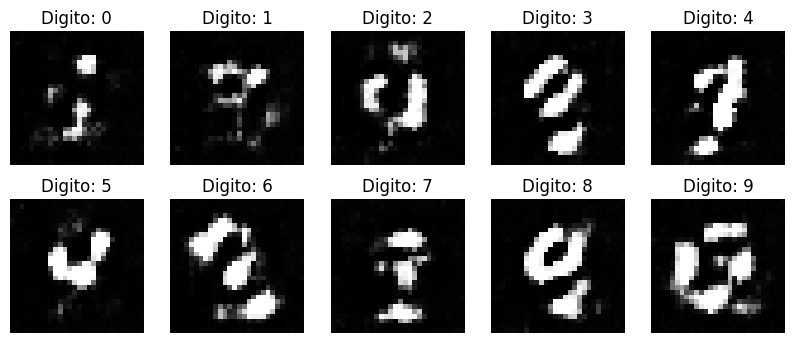

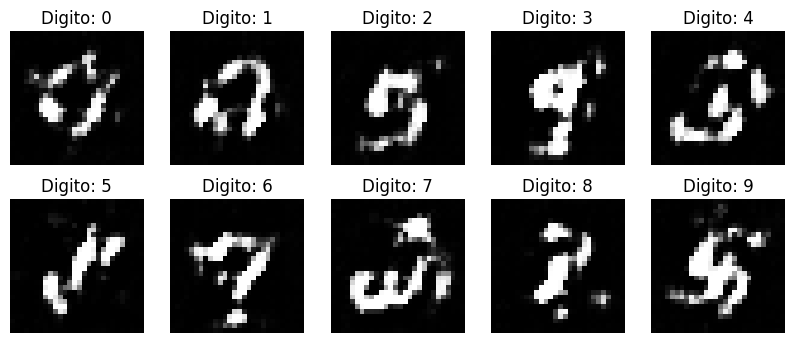

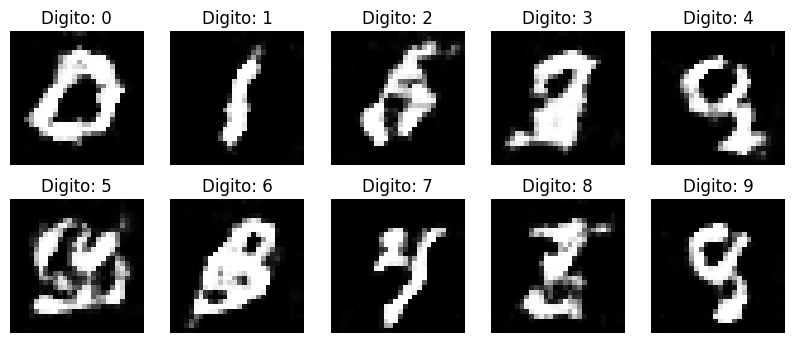

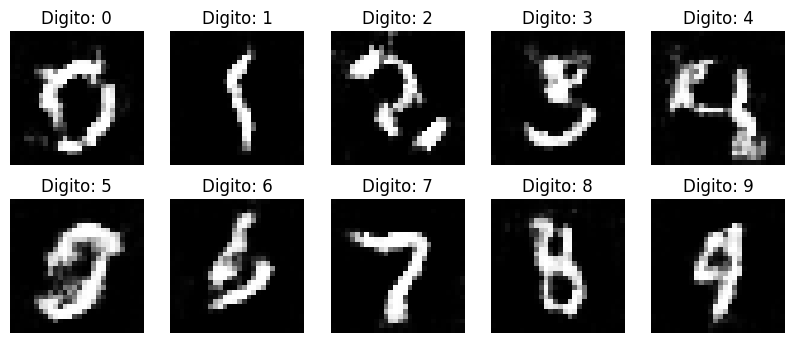

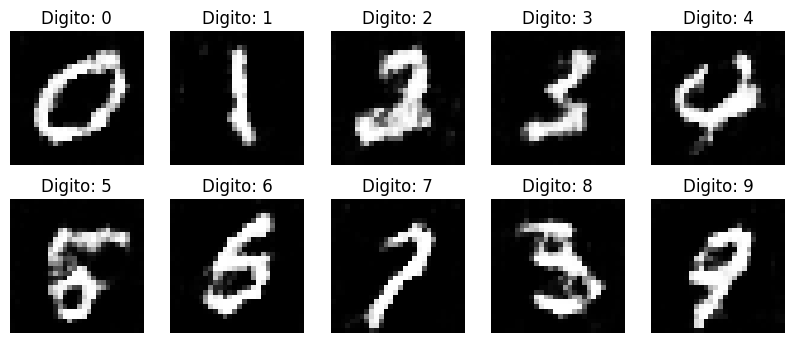

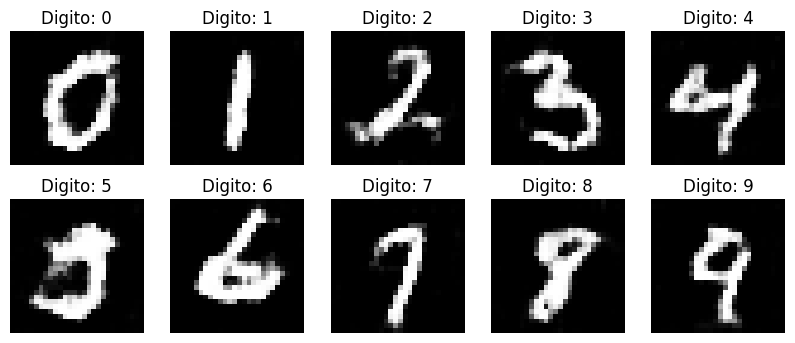

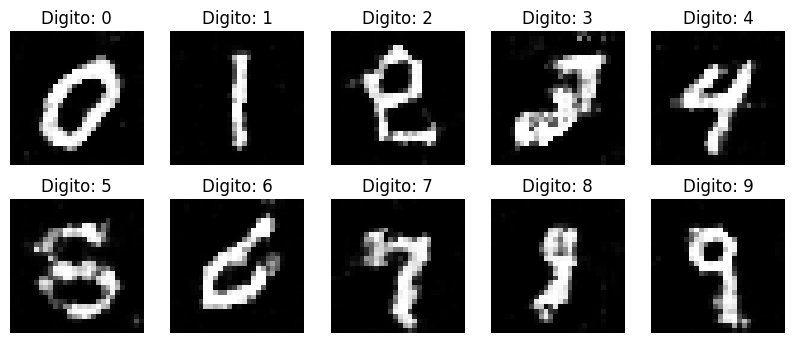

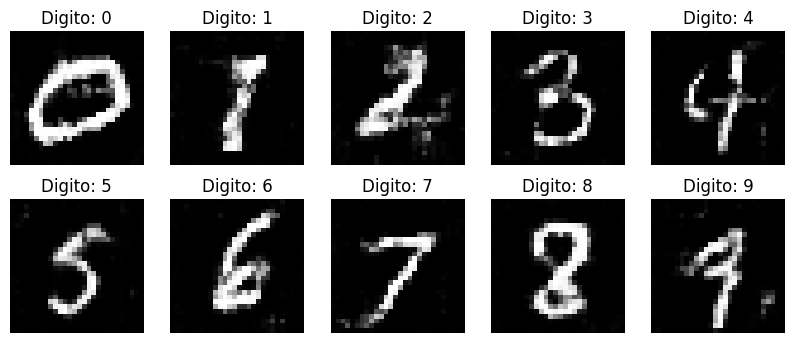

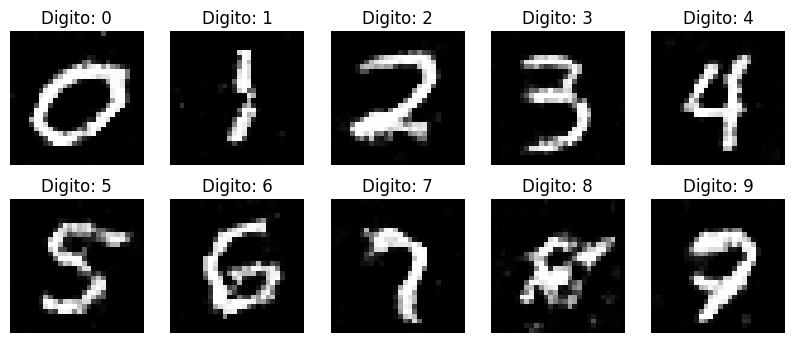

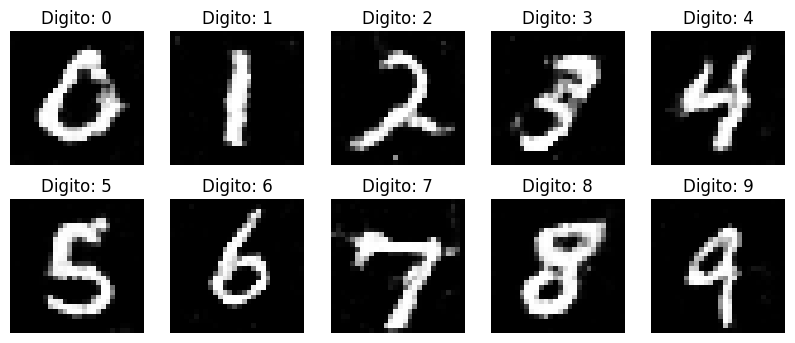

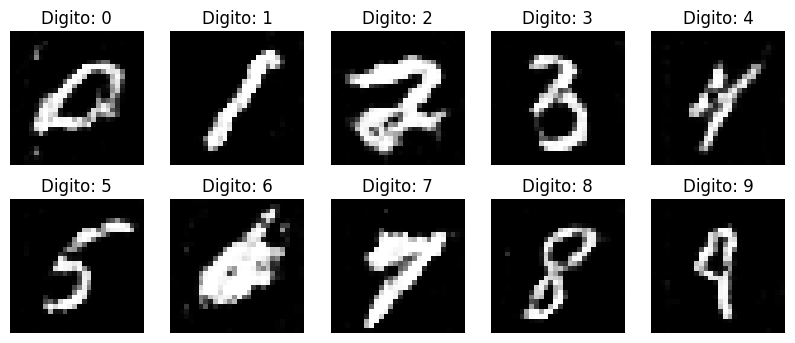

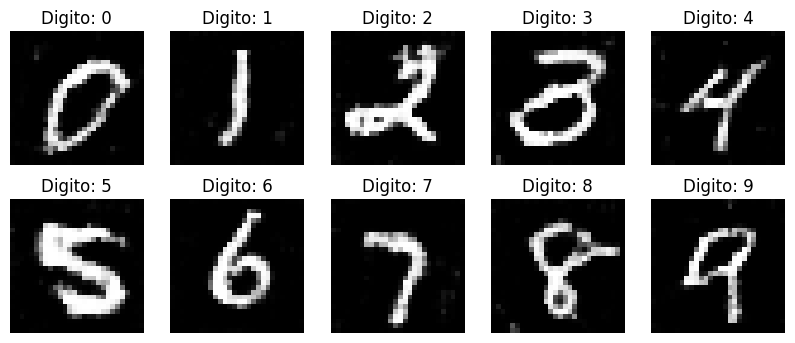

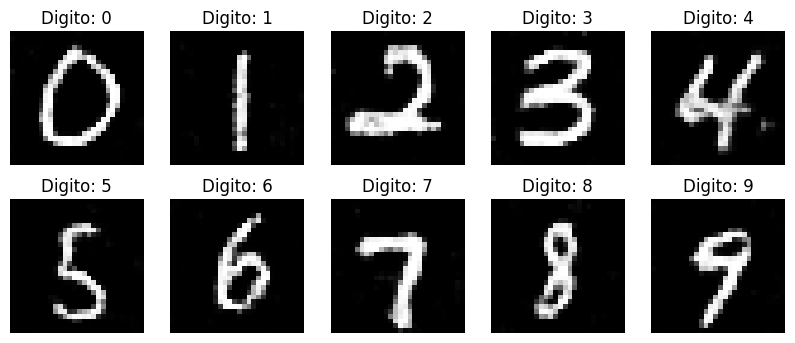

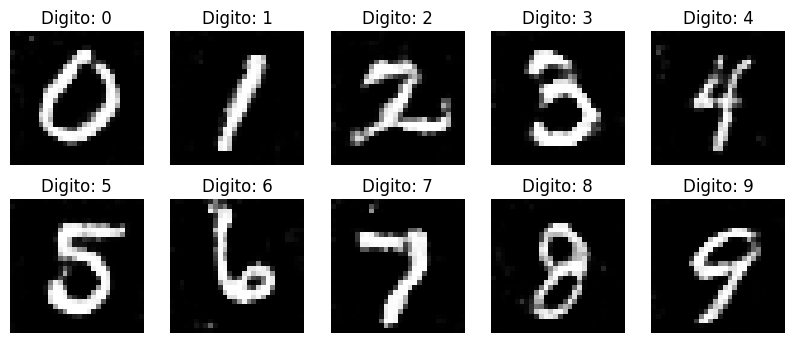

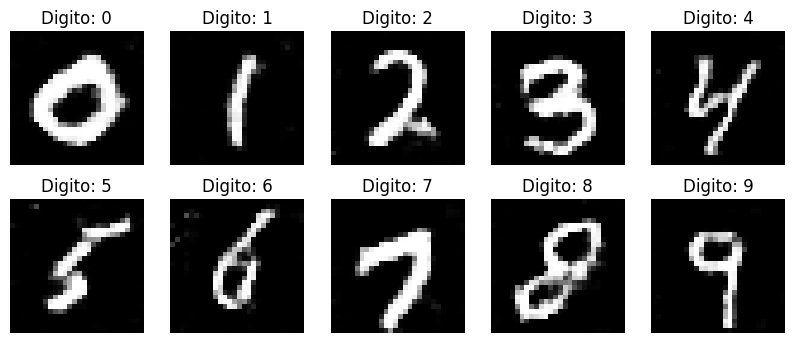

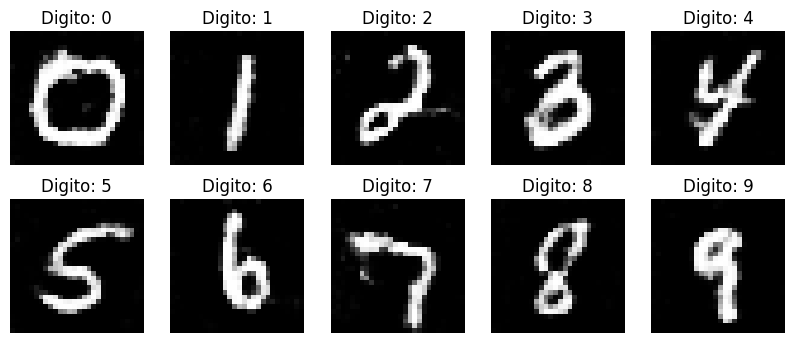

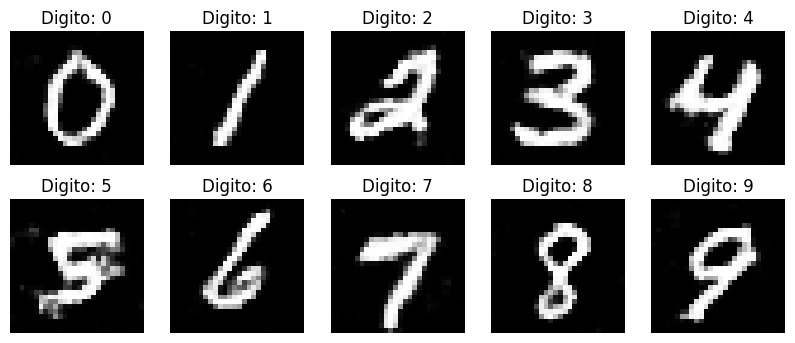

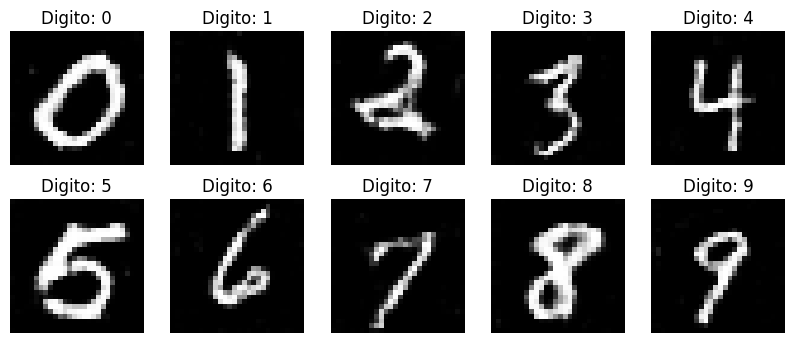

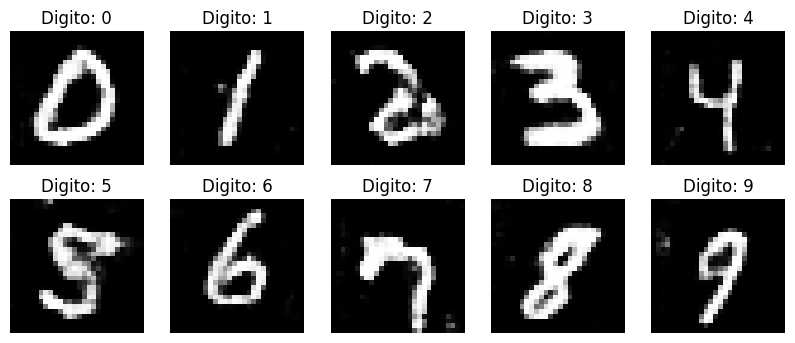

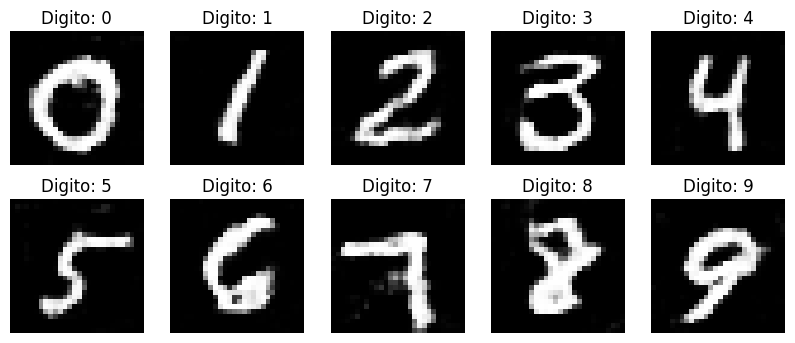

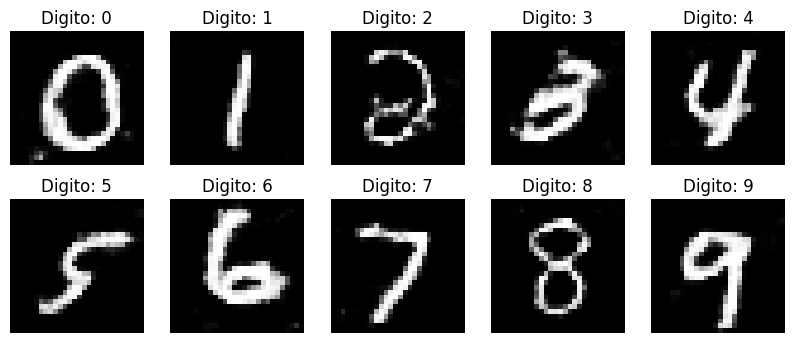

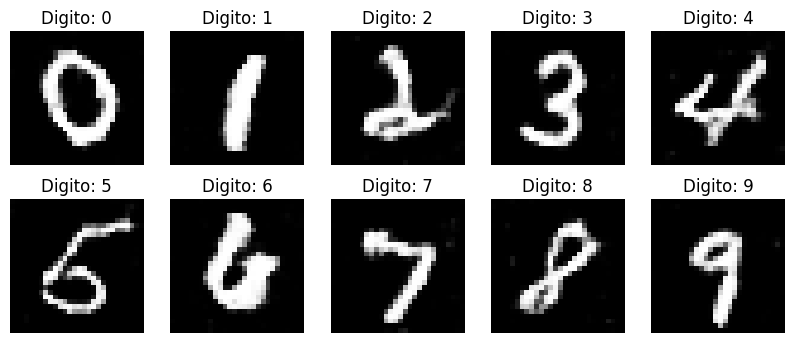

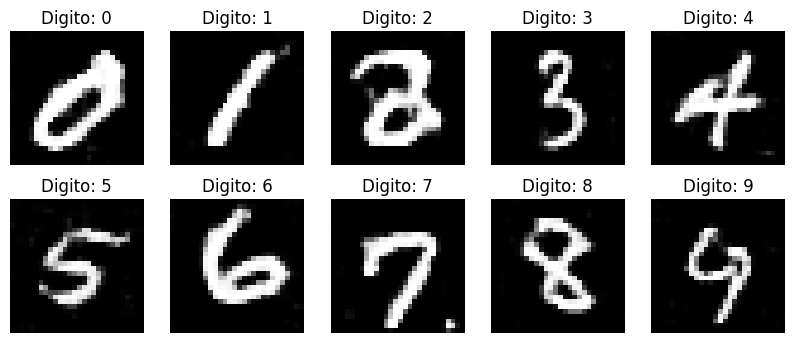

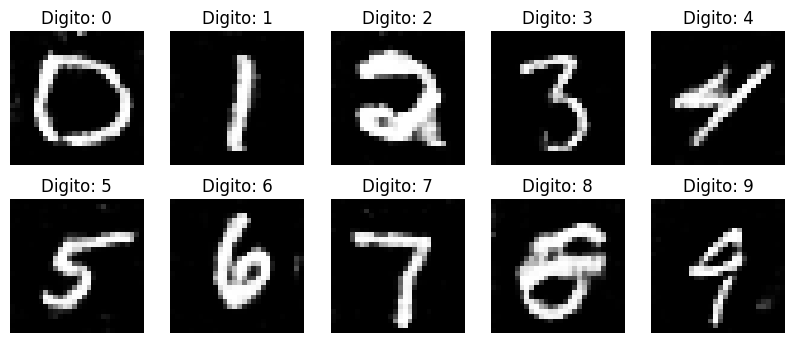

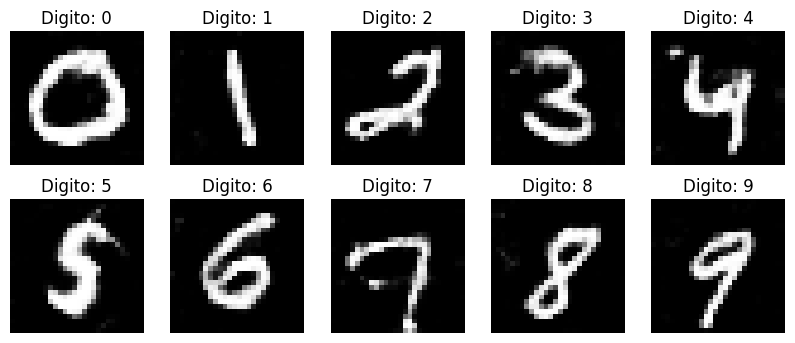

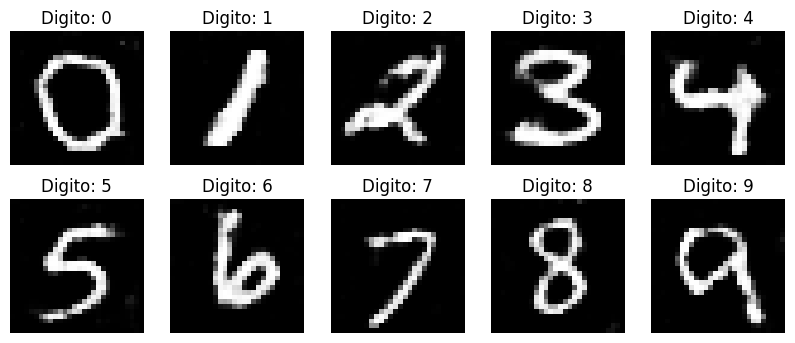

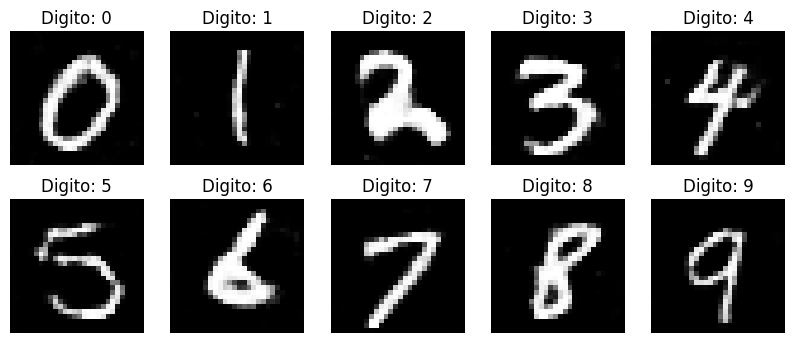

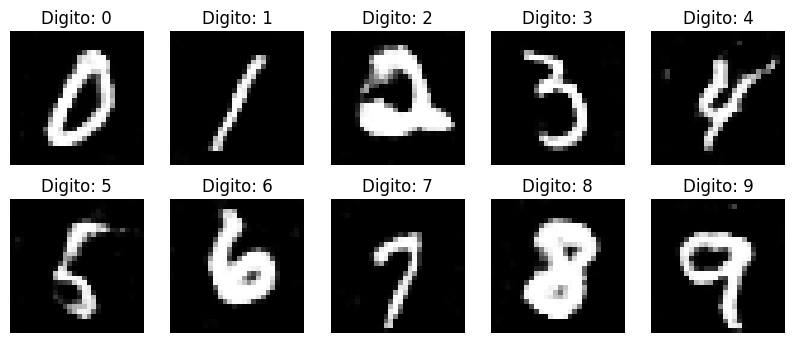

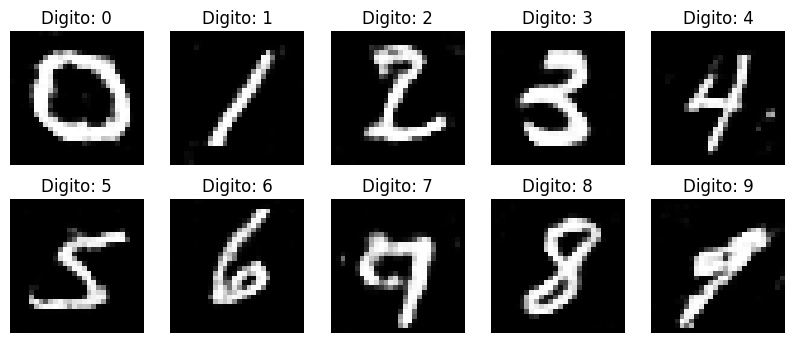

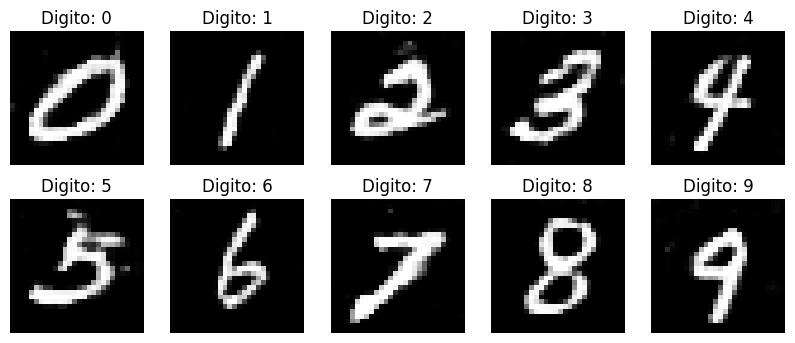

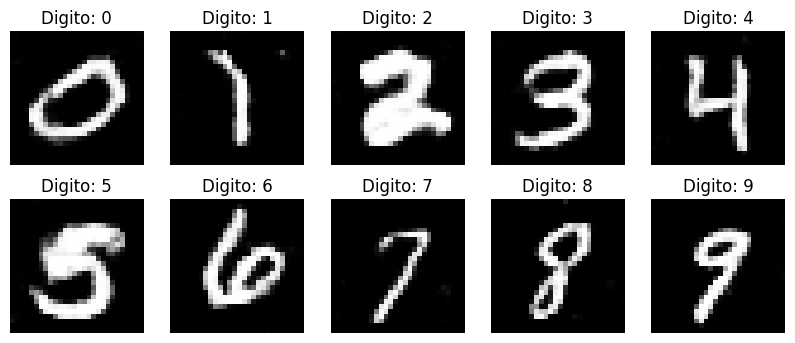

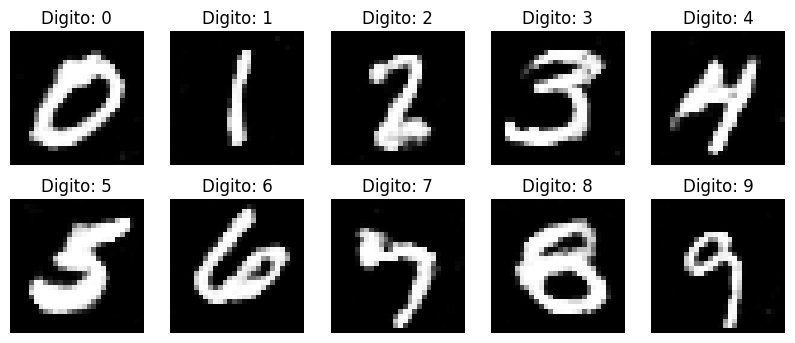

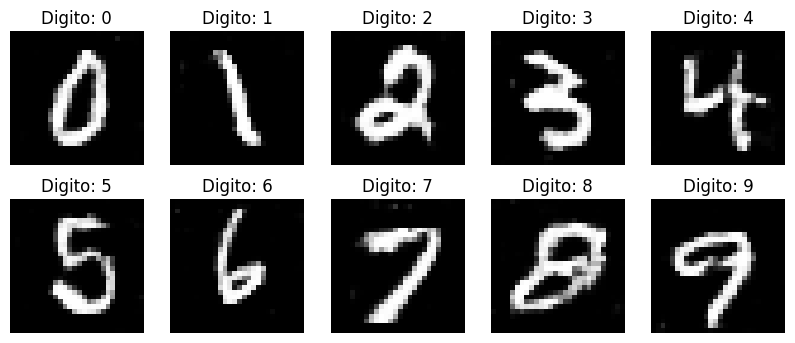

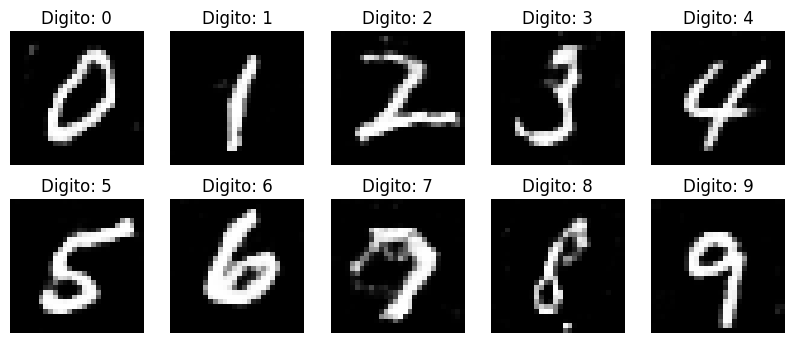

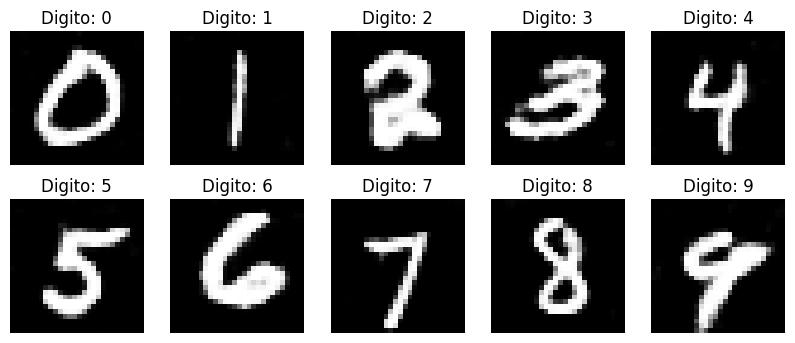

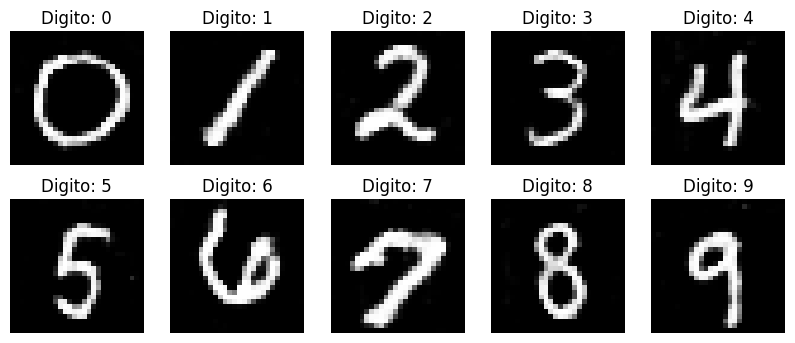

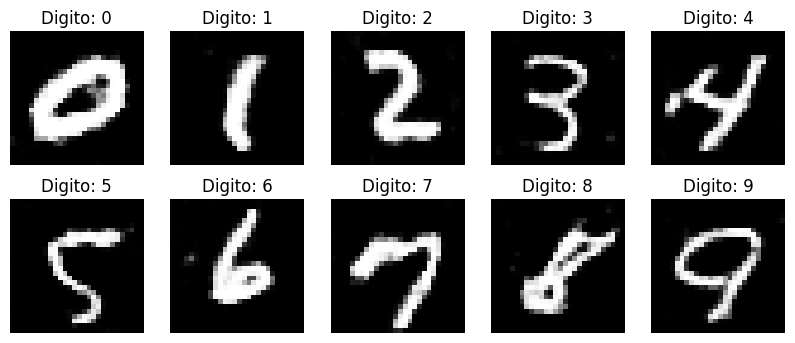

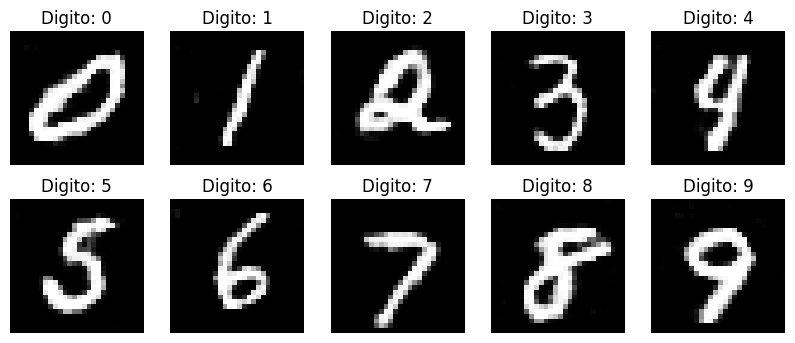

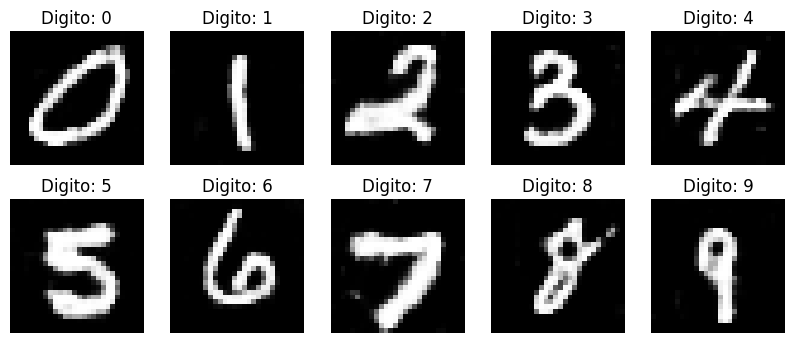

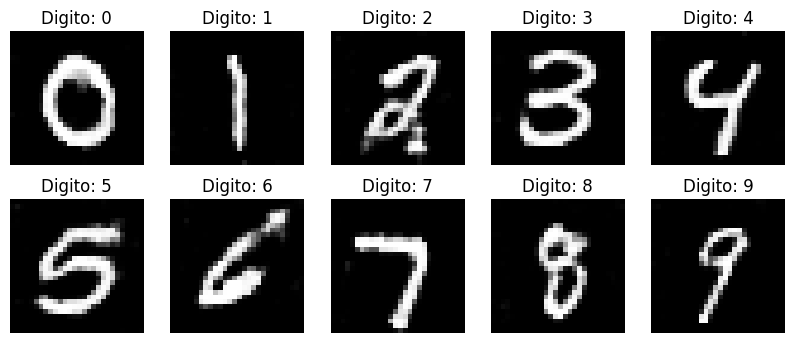

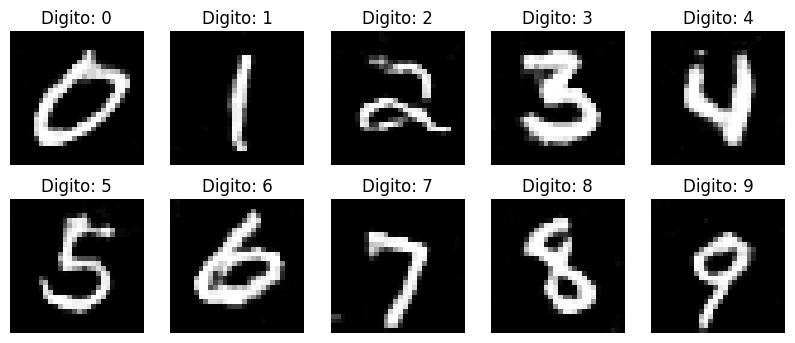

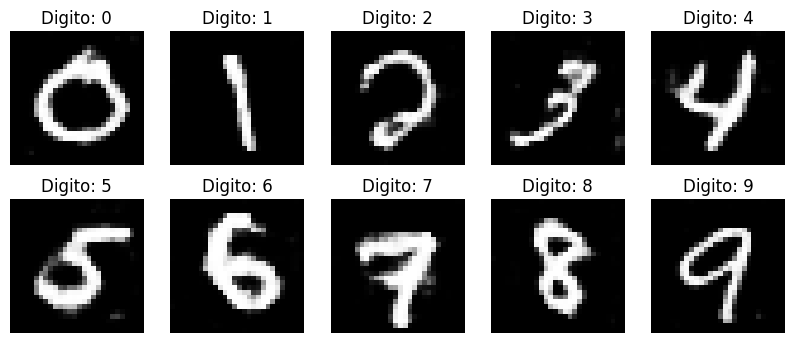

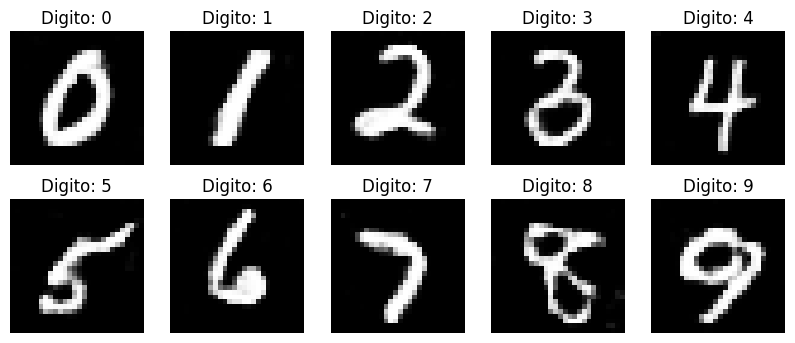

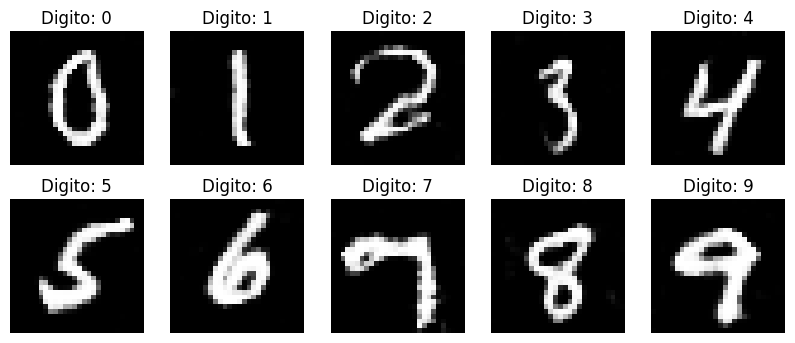

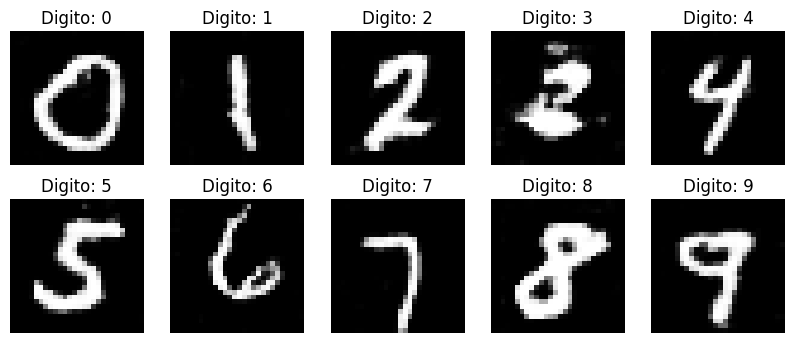

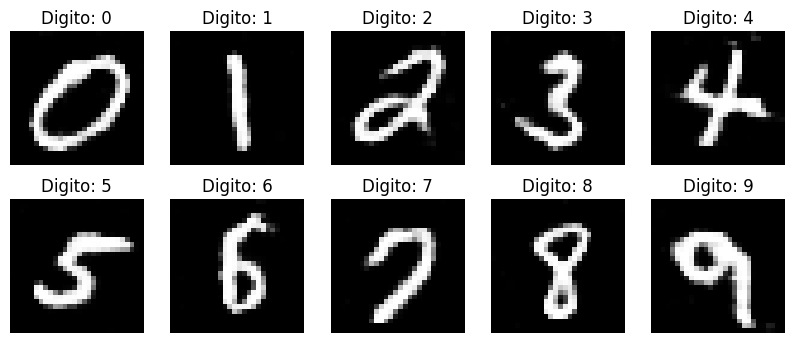

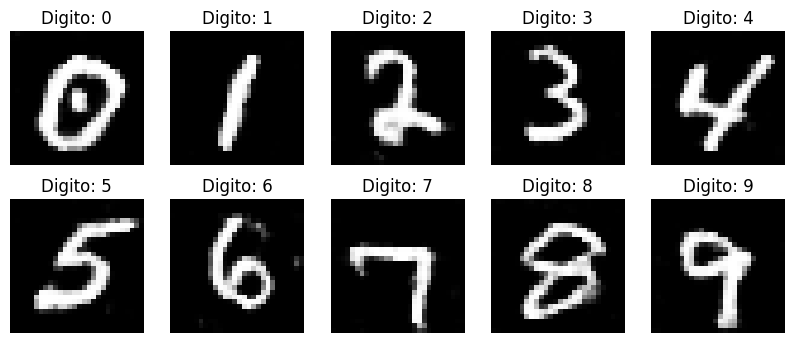

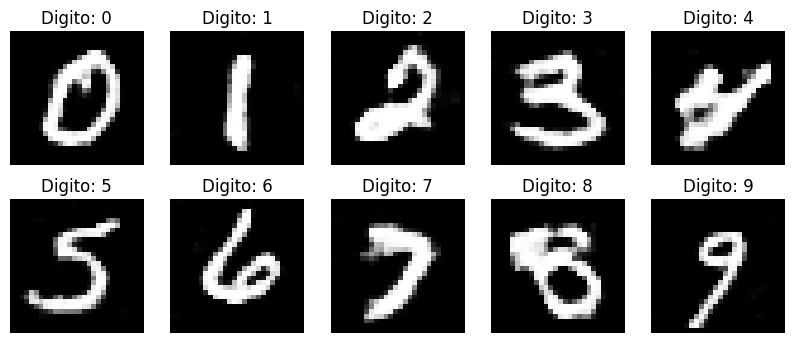

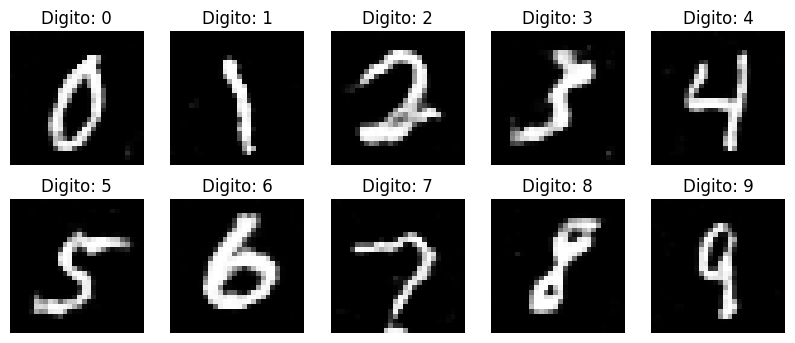

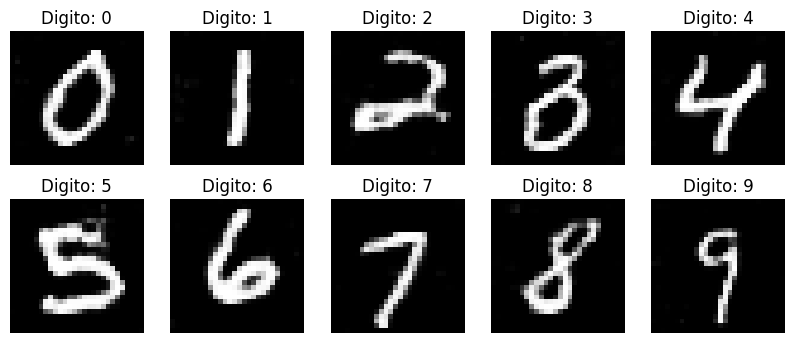

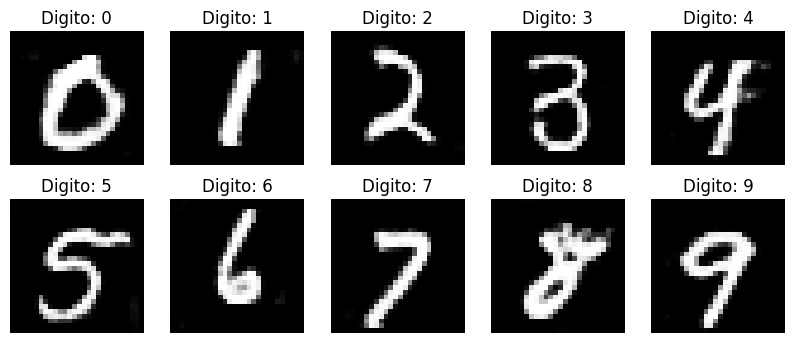

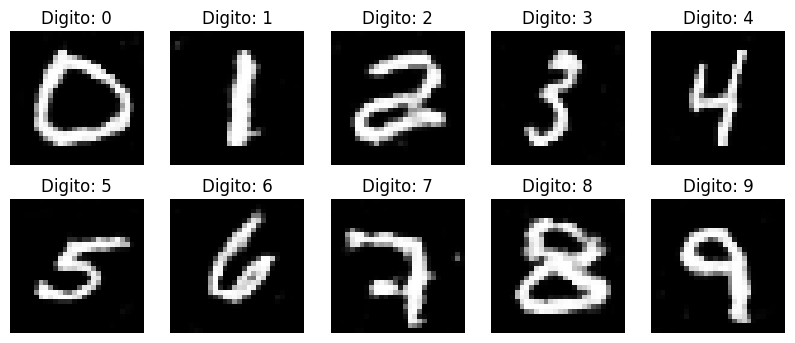

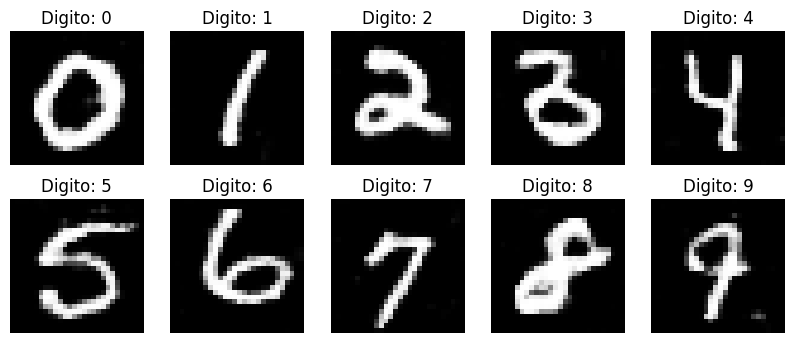

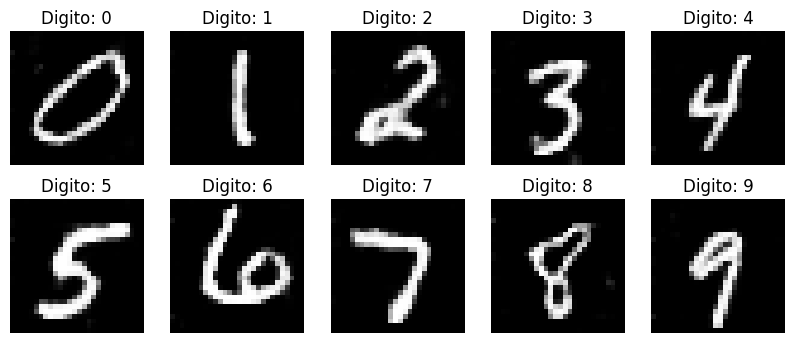

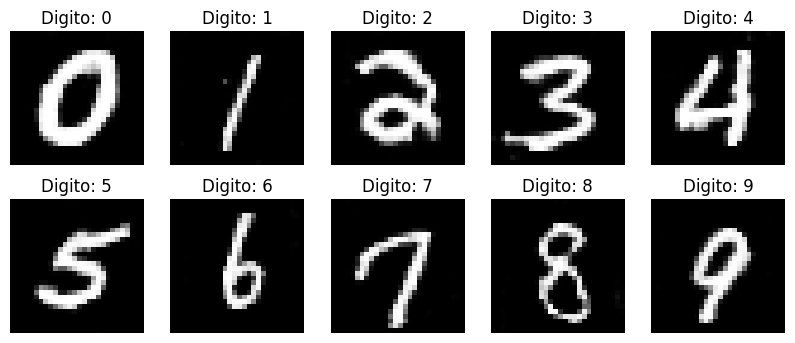

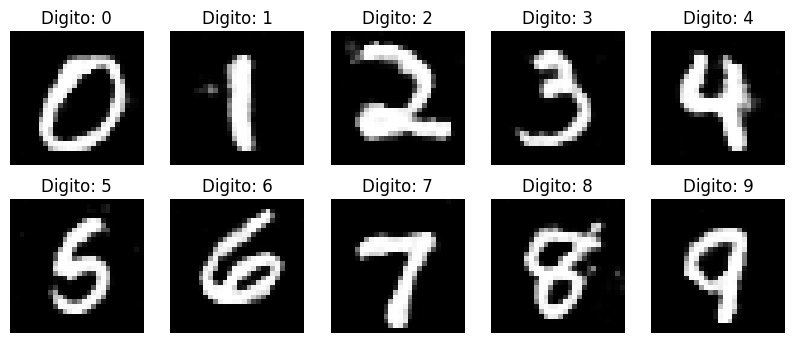

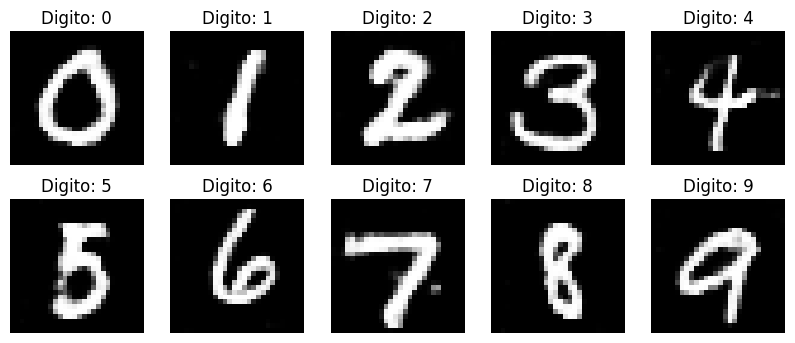

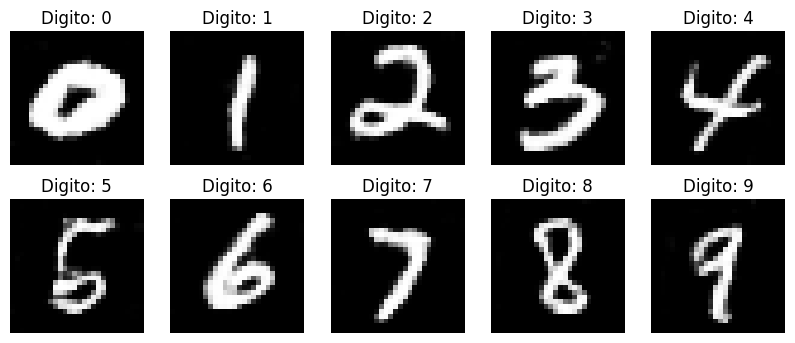

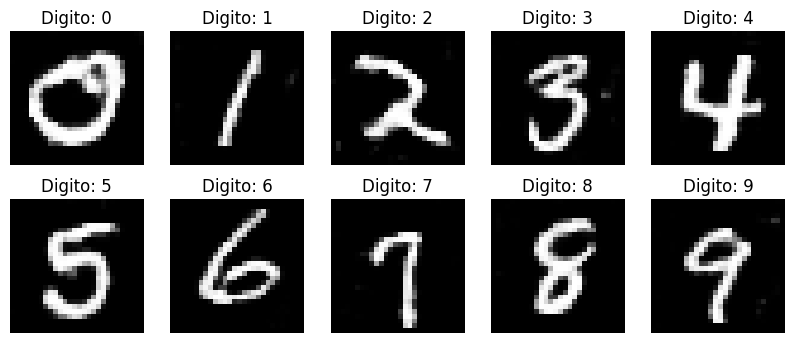

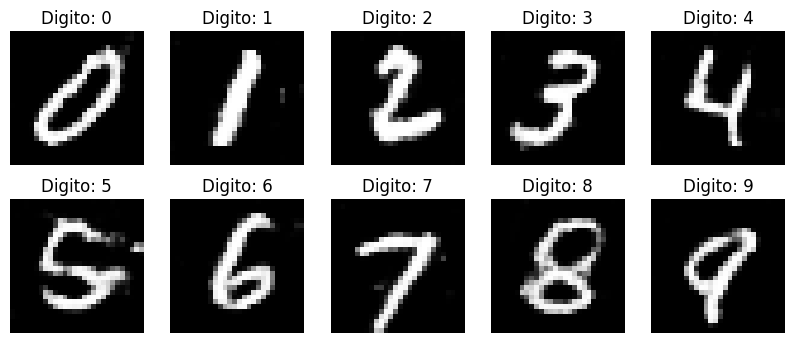

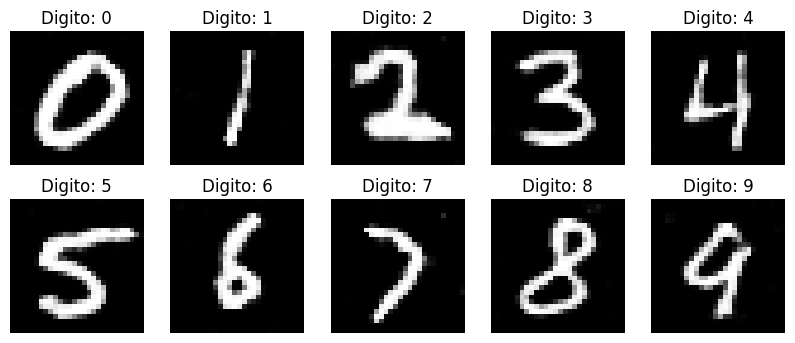

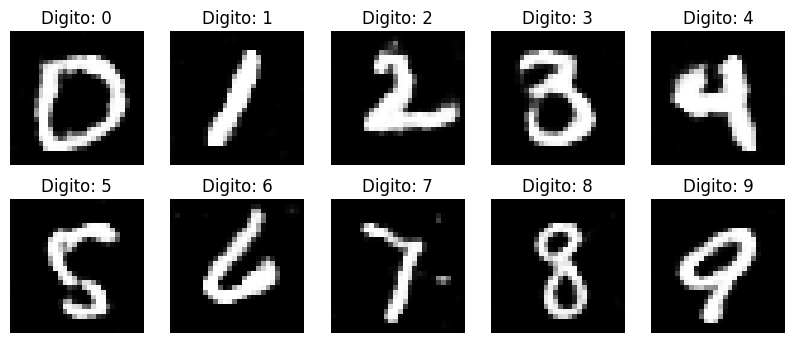

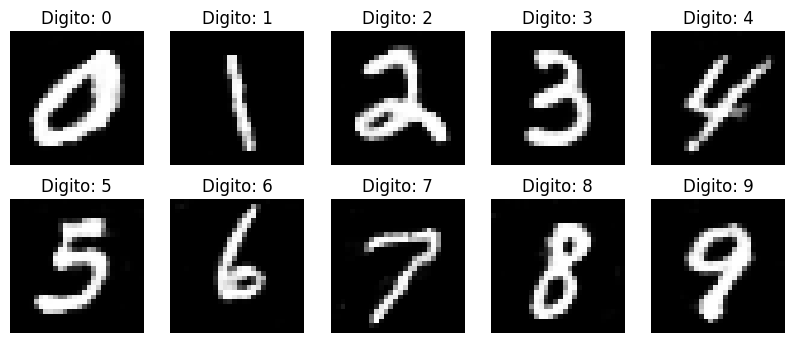

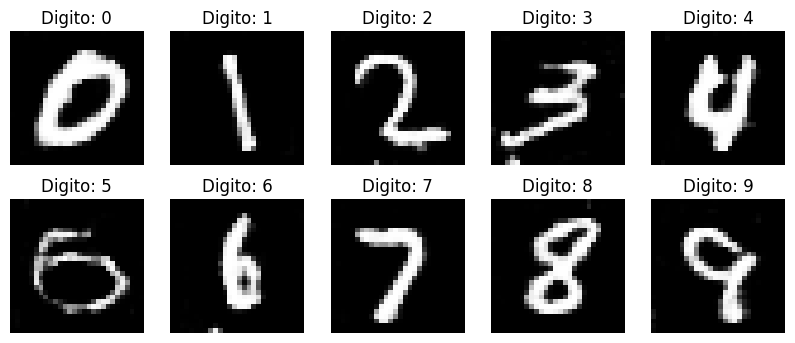

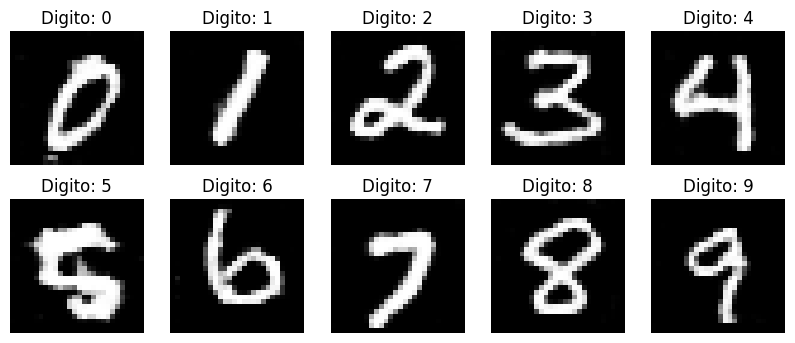

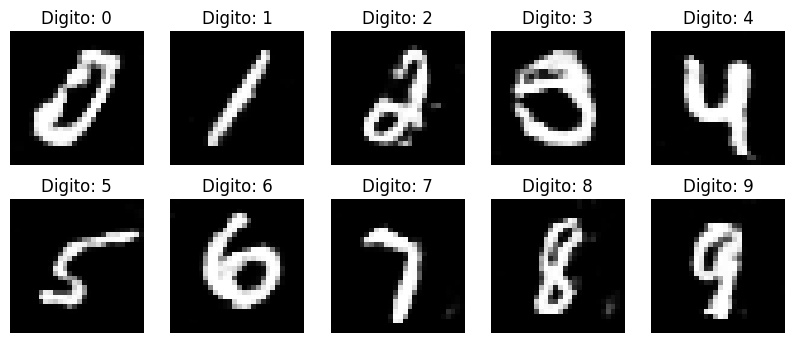

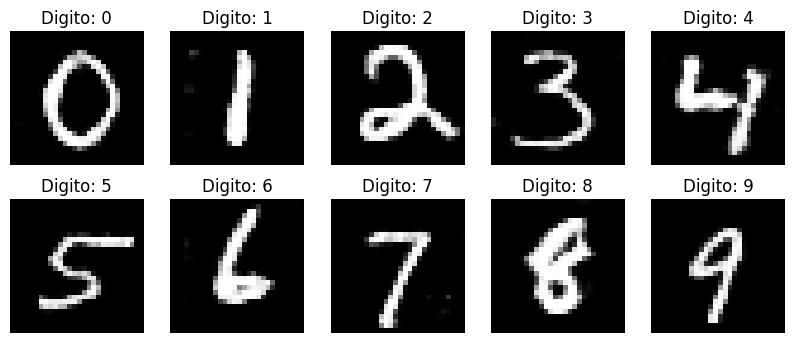

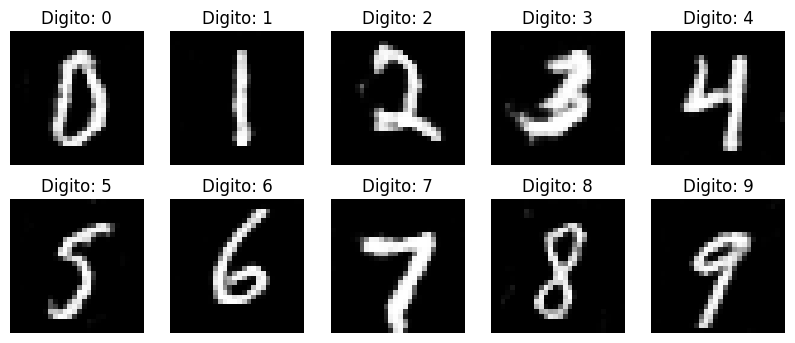

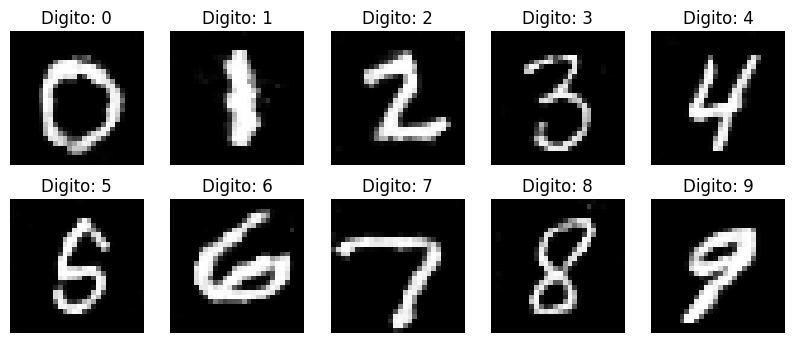

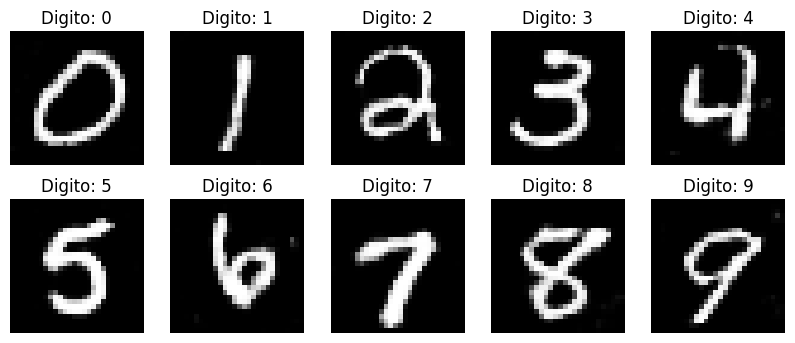

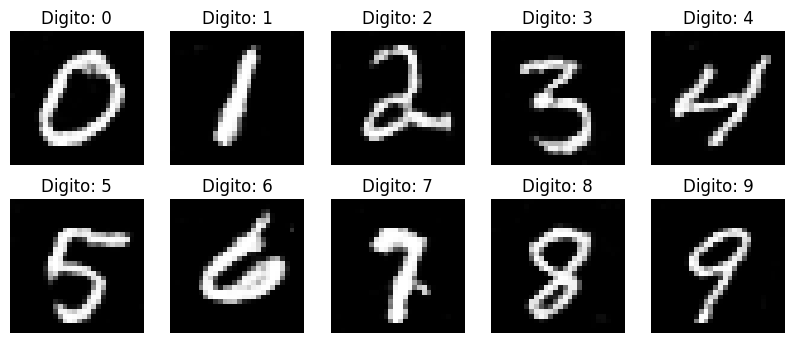

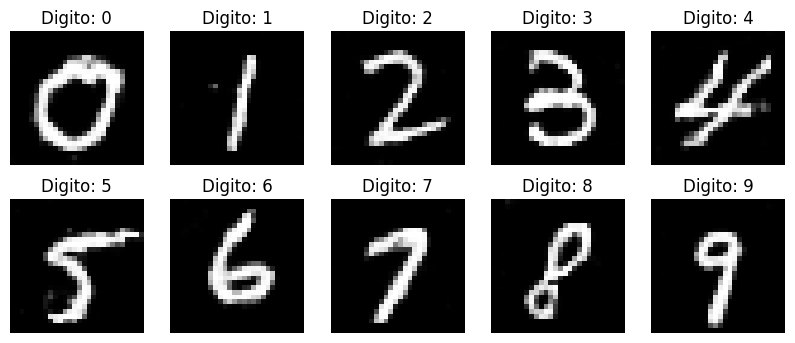

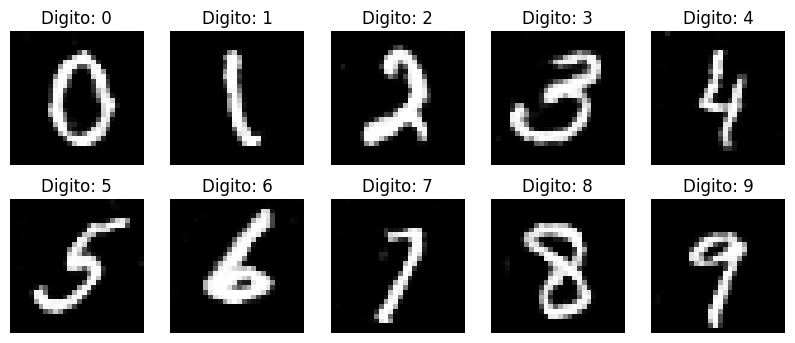

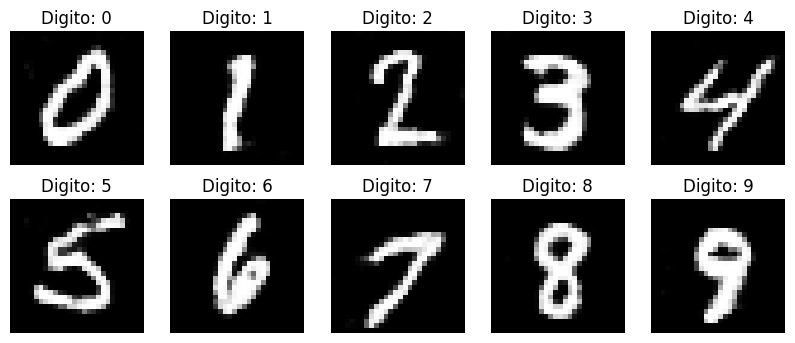

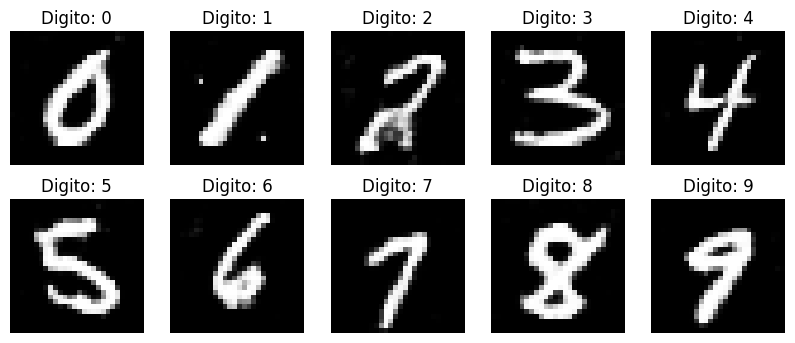

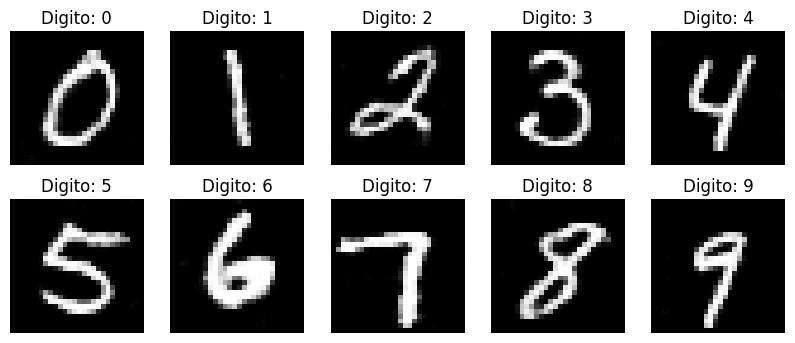

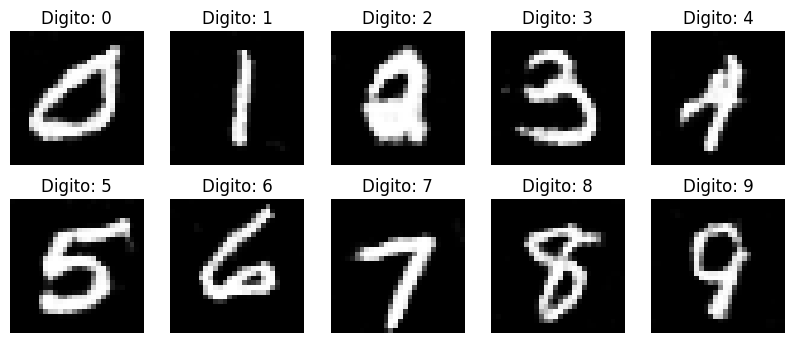

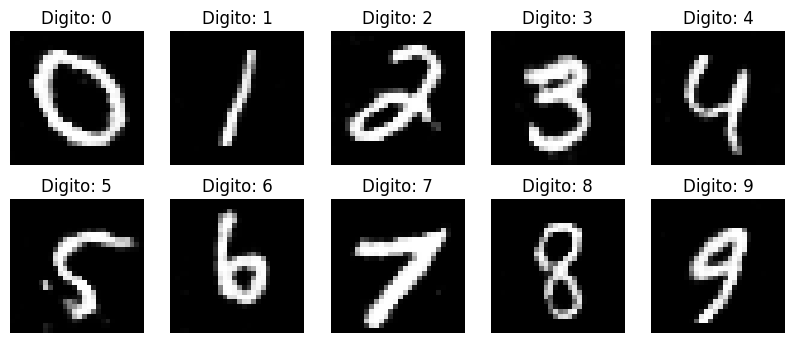

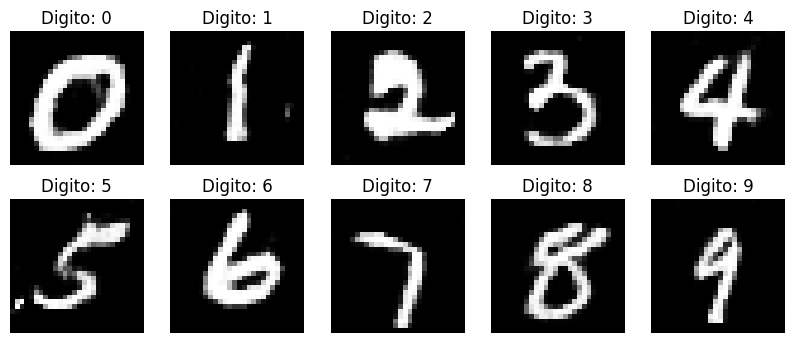

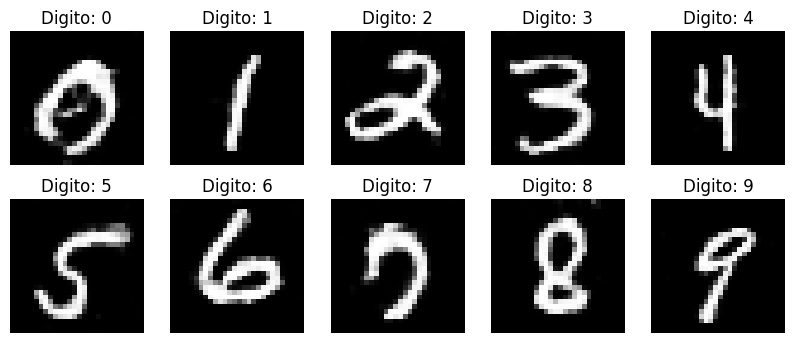

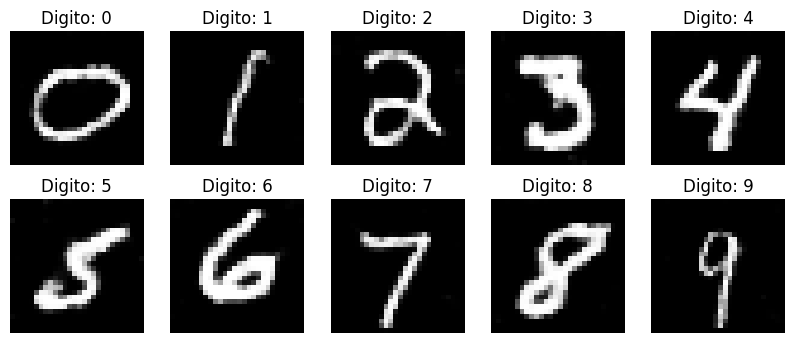

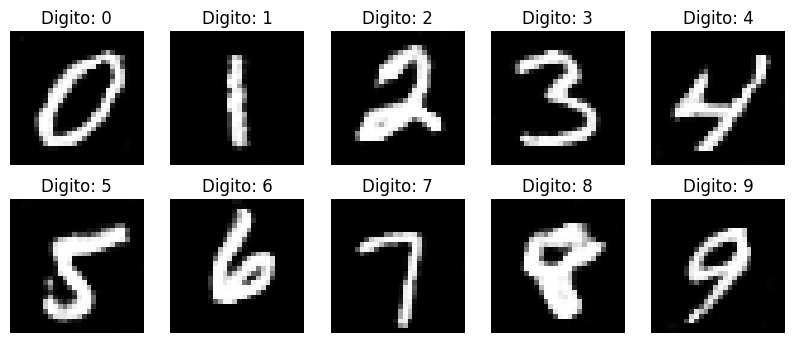

In [55]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=500)

In [56]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np

In [57]:
model = load_model('C:\\Users\\Mark\\Desktop\\MásterIA\\RNN\\Practicas\\generative.h5')

In [58]:
latent_points, labels = generate_latent_points(100, 100)

In [59]:
labels = asarray([x for _ in range(10) for x in range(10)])
X  = model.predict([latent_points, labels])
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

4/4 [==============================] - 1s 120ms/step


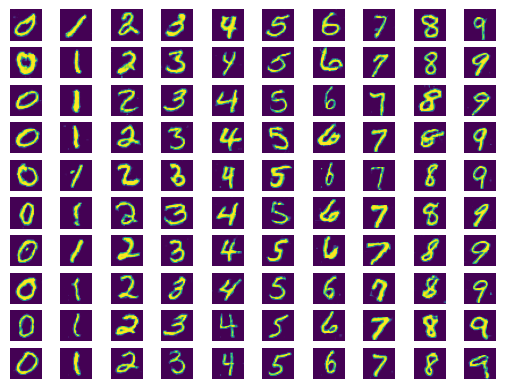

In [60]:
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()
    
show_plot(X, 10)